# Submission Final for San Francisco Crime Classification

MIDS W207 final project

DATASCI W207 Applied Machine Learning, Section 6


In this notebook we will work on the problem proposed by Kaggle named: San Francisco Crime Classification<br>
You can find more info here: https://www.kaggle.com/c/sf-crime/overview/description
<br><br>
The objective of this notebook is to classify a crime using the covariantes that is presented by the data set.
In order to assess the performance we will use logloss.
<br>
The team has developed a pipeline to test different possibilities and is using GridSearch to find the optimal parameters. Multiple ML algorithms have been used, among those we have: KNN, Logistic Regression, and Random Forest, among others.


Project members:

* Linda Dong
* Arthur Lima
* Yang Yang Qian



In [1]:
# basic standard libraries
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
import inspect
import datetime

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

# we will using seaborn for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

# we will also need our custom data transformers
%reload_ext autoreload
%autoreload 2
import src.features.build_features as bf

# Loads Data

In [2]:
train_pd = pd.read_csv("../data/raw/train.csv.zip", compression="zip")
test_pd = pd.read_csv("../data/raw/test.csv.zip", compression="zip")
sample_submissions = pd.read_csv("../data/raw/sampleSubmission.csv.zip", compression="zip")

In [37]:
# shuffles the train and test dataframes
# no dev set at this point, because we intend to use cross validation later
train_data, train_labels, dev_data, dev_labels, test_data, test_ids = bf.prep_data(train_pd, test_pd, dev_size=0.1)

## PCA

We used PCA to reduce the number of features needed to train on. Objective was to preserve as much of the variance in the data as possible, while projecting down to a lower number of dimensions. 

We plotted the number of components vs the explained variance, and does not look like any of the components dominate in the data. There doesn't seem to be a good "elbow" we can use to justify picking a particular number of components.

Note, we chose to use mostly non-Address related features for PCA. We found that if included Address-based features, we would have had to use TruncatedSVD instead of PCA, because of the size of the resulting sparse matrix.

In [5]:
def do_pca(train_data, dev_data=None, rs = 0):
    # ingredients for our pipeline
#     selector1 = bf.DataFrameSelector(attribute_names = ["X", "Y", "Dates", "DayOfWeek", "PdDistrict", "Address"], as_df = True)
    selector1 = bf.DataFrameSelector(attribute_names = ["X", "Y", "Dates", "DayOfWeek", "PdDistrict"], as_df = True)
    sfcc = bf.SFCCTransformer()
    pca = PCA(n_components = 100, random_state = rs)
    
    # sets up the pipelines to transform the data and extract new features
    pipe = Pipeline([
        ("selector1", selector1)
        ,("sfcc", sfcc)
        ,("pca", pca)
    ])
    
    # fits our PCA 
    train_prepared = pipe.fit_transform(train_data)
    if dev_data is not None:
        dev_prepared = pipe.transform(dev_data)
        return train_prepared, dev_prepared
    else:
        return pca
    
train_pca, dev_pca = do_pca(train_data, dev_data)

In [ ]:
sns.set(rc = {"figure.figsize" : (6, 4)})
ax = sns.lineplot(x = np.arange(0, results_pca.components_.shape[0]), y = np.cumsum(results_pca.explained_variance_ratio_))
plt.title("%s pct of total variance explained by %s components" % (np.round(results_pca.explained_variance_ratio_.sum() * 100, 0).astype(int) , results_pca.components_.shape[0]))
plt.show()

In [ ]:
len(np.where(np.cumsum(results_pca.explained_variance_ratio_) < 0.8)[0])

In [5]:
# shuffles the train and test dataframes
train_data, train_labels, dev_data, dev_labels, test_data, test_ids = bf.prep_data(train_pd, test_pd, dev_size = 0.2)

## logistic regression & PCA

no addresses, Linda

In [6]:
from sklearn.linear_model import LogisticRegression

def do_lr(train_data, train_labels, rs = 0):
    log = LogisticRegression(n_jobs=-1, verbose=1)
    pipe = Pipeline([
        ("log", log)
    ])

    param_grid = {
        'log__penalty': ['l1', 'l2'],
        'log__C': [1.0],
    }

    search = GridSearchCV(pipe, param_grid, scoring='neg_log_loss' ,iid = True, cv = 3, return_train_score = False)

    _ = search.fit(train_data, train_labels)
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)
    return search
    
search_lr = do_lr(train_pca, train_labels)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]Best parameter (CV score=-2.561):
{'log__C': 1.0, 'log__penalty': 'l1'}


In [10]:
# Store results in pkl file
import _pickle
f = open("logistic_l1_l2.pkl", "wb")
_pickle.dump(search_lr, f)
f.close()

Text(0.5, 1.0, 'Train')

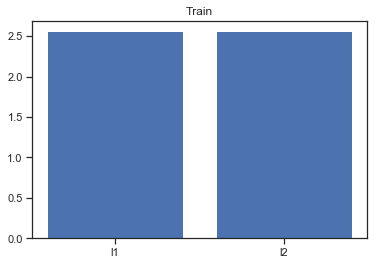

In [22]:
y = search_lr.cv_results_["mean_test_score"]
x = [x['log__penalty'] for x in search_lr.cv_results_["params"]]
plt.bar(x, -y)
plt.title("Train")

dev_log_loss 2.559057742465086


<BarContainer object of 1 artists>

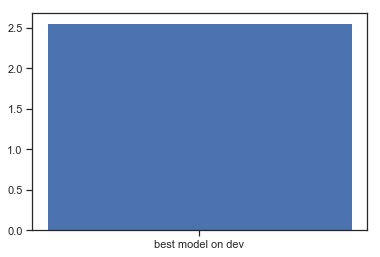

In [26]:
# plot best model on heldout dev performance
from sklearn.metrics import log_loss
predsproba_dev = search_lr.best_estimator_.predict_proba(dev_pca)
dev_results = log_loss(dev_labels, predsproba_dev, labels=np.unique(train_labels))
print("dev_log_loss", dev_results)
plt.bar("best model on dev", dev_results)

In [ ]:
# working on seeing if it makes sense to remove 0-weighted features from L1 and retrain (like in homework)

## Preparing to Submit to Kaggle

In [40]:
def do_pca(train_data, dev_data=None, test_data=None, rs = 0):
    # ingredients for our pipeline
#     selector1 = bf.DataFrameSelector(attribute_names = ["X", "Y", "Dates", "DayOfWeek", "PdDistrict", "Address"], as_df = True)
    selector1 = bf.DataFrameSelector(attribute_names = ["X", "Y", "Dates", "DayOfWeek", "PdDistrict"], as_df = True)
    sfcc = bf.SFCCTransformer()
    pca = PCA(n_components = 100, random_state = rs)
    
    # sets up the pipelines to transform the data and extract new features
    pipe = Pipeline([
        ("selector1", selector1)
        ,("sfcc", sfcc)
        ,("pca", pca)
    ])
    
    
    # fits our PCA 
    train_prepared = pipe.fit_transform(train_data)
    return_vals = [train_prepared]
    if dev_data is not None:
        dev_prepared = pipe.transform(dev_data)
        return_vals.append(dev_prepared)
    if test_data is not None:
        test_prepared = pipe.transform(test_data)
        return_vals.append(test_prepared)
        
    return return_vals
    
_, _, test_pca = do_pca(train_data, dev_data, test_data)

ValueError: operands could not be broadcast together with shapes (884262,140) (139,) 

In [39]:
np.array(test_data).shape

(884262, 6)

In [ ]:
predsproba_ = search_lr.best_estimator_.predict_proba(test_pca)

In [28]:
# converts predicted probabilities into submission panda
from src.features.build_features import prep_submissions
submissions = prep_submissions(predsproba_, train_pd.Category)

print(submissions.shape)
print(submissions.head(3))

# checks submission has the correct number of rows and columns
assert(sample_submissions.shape[0] == submissions.shape[0])
assert(sample_submissions.shape[1] == submissions.shape[1])

NameError: name 'predsproba' is not defined

In [ ]:
# save submissions to disk
submissions.to_csv("../data/processed/llog_submission.csv.gz", index = False, compression = "gzip")

# Appendicies

## More models

We ran some more models on other notebooks, because of computing limitations

* 1.0-ASL-submission03.1.ipynb
    + https://github.com/ucbiyyq/w207re-final-proj/blob/master/notebooks/1.0-ASL-submission03.ipynb
* 2.0-ld-submission03-mlp-xbt-0419.ipynb
    + https://github.com/ucbiyyq/w207re-final-proj/blob/master/notebooks/2.0-ld-submission03-mlp-xbt-0419.ipynb

In [44]:
    selector1 = bf.DataFrameSelector(attribute_names = ["X", "Y", "Dates", "DayOfWeek", "PdDistrict"], as_df = True)
    sfcc = bf.SFCCTransformer()
    pca = PCA(n_components = 100, random_state = 0)
    
    # sets up the pipelines to transform the data and extract new features
    pipe = Pipeline([
        ("selector1", selector1)
        ,("sfcc", sfcc)
    ])
    
    train_prepared = pipe.fit_transform(train_data)

In [46]:
    test_prepared = pipe.transform(test_data)

In [47]:
train_prepared.shape

(790244, 139)

Index(['X', 'Y', 'pdd_BAYVIEW', 'pdd_CENTRAL', 'pdd_INGLESIDE', 'pdd_MISSION',
       'pdd_NORTHERN', 'pdd_PARK', 'pdd_RICHMOND', 'pdd_SOUTHERN',
       ...
       'day_of_month_sin', 'day_of_month_cos', 'day_of_year_sin',
       'day_of_year_cos', 'week_of_year_sin', 'week_of_year_cos',
       'month_of_year_sin', 'month_of_year_cos', 'quarter_of_year_sin',
       'quarter_of_year_cos'],
      dtype='object', length=140)

In [52]:
for k in test_prepared.keys():
    if k not in train_prepared.keys():
        print(k)

woy_1
woy_3
woy_5
woy_7
woy_9
woy_11
woy_13
woy_15
woy_17
woy_19
woy_21
woy_23
woy_25
woy_27
woy_29
woy_31
woy_33
woy_35
woy_37
woy_39
woy_41
woy_43
woy_45
woy_47
woy_49
woy_51
woy_53
